In [2]:
1+1

2

In [3]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load test predicted probabilities

In [6]:
main_dir = '/tf/notebooks/'

In [7]:
probs_path = main_dir+'final-project/Classification/data/gender'

In [8]:
test_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'test_pred_probs_mlp_ngram.npy'))
test_pred_probs_cnn = np.load(os.path.join(probs_path, 'test_pred_probs_cnn.npy'))
test_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'test_pred_probs_cnn_aggr_chunk.npy'))

In [9]:
len(test_pred_probs_mlp_ngram), len(test_pred_probs_cnn), len(test_pred_probs_cnn_aggr_chunk)

(62716, 62716, 62716)

In [10]:
with open(os.path.join(probs_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)
with open(os.path.join(probs_path, 'test_list'), 'rb') as fp:
    test_list = pickle.load(fp)

In [11]:
len(test_ids), len(test_target), len(test_list)

(62716, 62716, 62716)

In [12]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(test_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62716, 17)

In [13]:
pred_df = pd.DataFrame({'ids': np.asarray(test_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': test_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': test_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': test_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(62716, 4)

In [14]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,1070082863,0.262876,0.343526,0.477064
1,1020062705,0.366461,0.461758,0.492565
2,1060179537,0.984058,0.665958,0.996153
3,1130064416,0.974944,0.761403,0.961752
4,1020001636,0.354996,0.527600,0.247501


In [15]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(62716, 21)

In [16]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk',
]

In [17]:
descr_pred_df[preds+['Female']].groupby('Female').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Female,,,
0.0,0.316686,0.386005,0.425528
1.0,0.681357,0.694275,0.595124


In [18]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[preds].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(test_target==descr_pred_df['pred_combo'].values.flatten())

0.7625645768225014

### Save the main dataframe

In [19]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [20]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'test_gender_preds.pkl'))

### Evaluating final predictions

In [21]:
classes = ['Male', 'Female']

Confusion matrix, without normalization
[[23138  8220]
 [ 6671 24687]]
              precision    recall  f1-score   support

        Male       0.78      0.74      0.76     31358
      Female       0.75      0.79      0.77     31358

   micro avg       0.76      0.76      0.76     62716
   macro avg       0.76      0.76      0.76     62716
weighted avg       0.76      0.76      0.76     62716



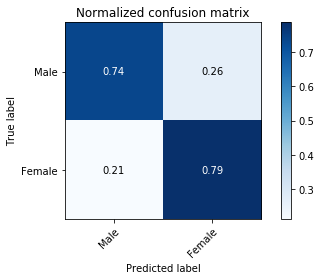

In [22]:
explore_data.plot_confusion_matrix(test_target, descr_pred_df['pred_combo'], classes, normalize=True)

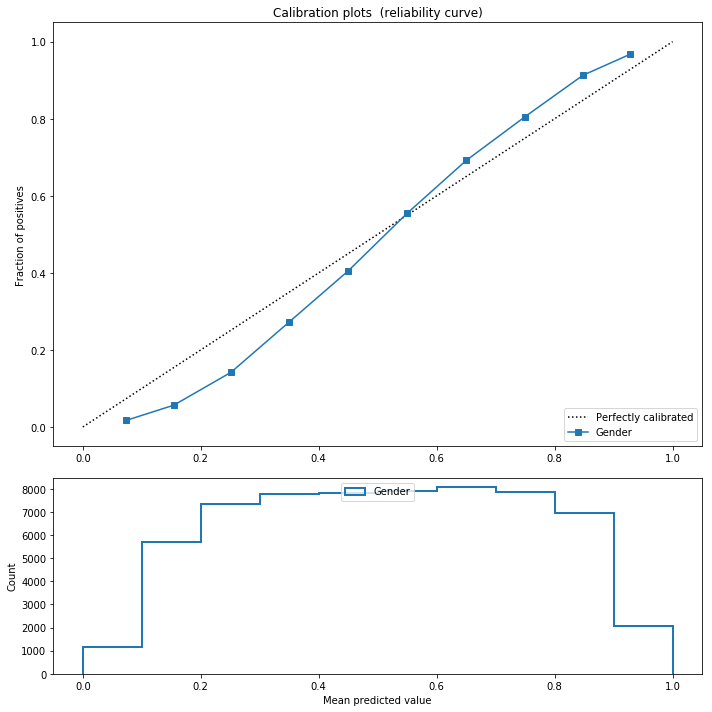

In [23]:
explore_data.plot_calibration_curve(test_target, descr_pred_df['pred_probs_combo'], 'Gender')

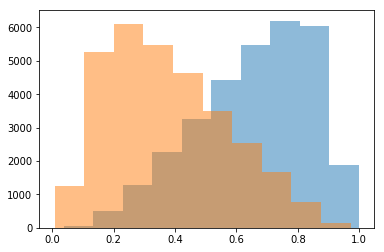

In [44]:
_=plt.hist(descr_pred_df[descr_pred_df.Female==1]['pred_probs_combo'], alpha=0.5)
_=plt.hist(descr_pred_df[descr_pred_df.Female==0]['pred_probs_combo'], alpha=0.5)
plt.show()

In [24]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   test_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge  Party_D  Chamber_H  AvgWordCount
base       0.5        0.17466  58.370671  0.62099   0.655479    392.725939


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.32,0.36,0.99,0.81,0.69,0.95
0.6,0.96,0.81,0.99,0.93,1.09,0.90
1.0,1.62,1.68,1.01,1.21,1.21,1.11


In [25]:
reload(explore_data)
explore_data.compare_ngrams(test_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,proud,996.0,1371.0,4206.0,573.0
1,unanimous,3304.0,1367.0,1299.0,554.0
2,ensure,1308.0,1647.0,5020.0,532.0
3,woman,373.0,414.0,3070.0,491.0
4,consent,3619.0,1489.0,1449.0,457.0
5,communities,1159.0,1596.0,5534.0,437.0
6,ought,2742.0,549.0,549.0,435.0
7,honor,1187.0,1803.0,4456.0,408.0
8,california,1504.0,1668.0,6496.0,408.0
9,womens,62.0,209.0,3118.0,376.0


## Congressperson level analysis

In [50]:
speaker_df = descr_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo', 'speech_id']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean'], 'Age': ['mean'], 'speech_id': ['count']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['Female_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1685, 9)

In [51]:
np.mean(speaker_df.Female_==speaker_df.Female_pred_)

0.6830860534124629

Confusion matrix, without normalization
[[945 517]
 [ 17 206]]
              precision    recall  f1-score   support

        Male       0.98      0.65      0.78      1462
      Female       0.28      0.92      0.44       223

   micro avg       0.68      0.68      0.68      1685
   macro avg       0.63      0.79      0.61      1685
weighted avg       0.89      0.68      0.73      1685



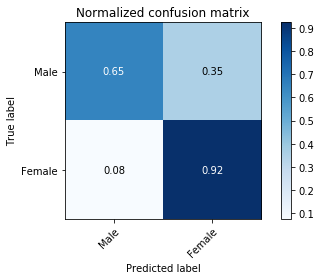

In [27]:
explore_data.plot_confusion_matrix(speaker_df.Female_, speaker_df.Female_pred_, classes, normalize=True)

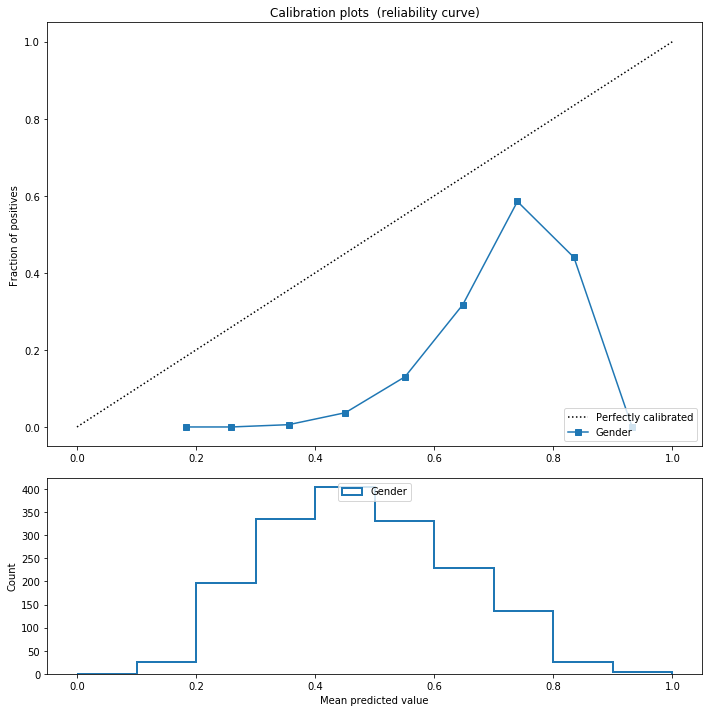

In [30]:
explore_data.plot_calibration_curve(speaker_df.Female_, speaker_df.pred_probs_combo_mean, 'Gender')

In [31]:
speaker_df.pred_probs_combo_count.median()

12.0

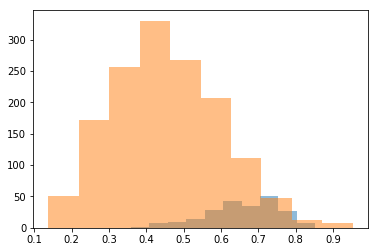

In [46]:
_=plt.hist(speaker_df[speaker_df.Female_==1]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[speaker_df.Female_==0]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

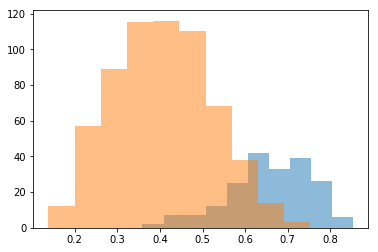

In [52]:
_=plt.hist(speaker_df[(speaker_df.Female_==1) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[(speaker_df.Female_==0) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

In [32]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(821, 9)

Confusion matrix, without normalization
[[490 132]
 [ 14 185]]
              precision    recall  f1-score   support

        Male       0.97      0.79      0.87       622
      Female       0.58      0.93      0.72       199

   micro avg       0.82      0.82      0.82       821
   macro avg       0.78      0.86      0.79       821
weighted avg       0.88      0.82      0.83       821



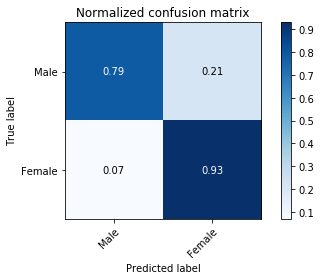

In [33]:
explore_data.plot_confusion_matrix(speaker_med_df.Female_, speaker_med_df.Female_pred_, classes, normalize=True)

In [34]:
tp = np.argmax(speaker_med_df[speaker_med_df.Female_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Female_==1].iloc[tp]

Full Name_                ADAMS, ALMA
Party_                              D
State_                             NC
Female_                             1
NonWhite_                           1
pred_probs_combo_mean        0.852684
pred_probs_combo_count             18
Age_mean                      69.7778
Female_pred_                     True
Name: 6, dtype: object

In [35]:
tn = np.argmin(speaker_med_df[speaker_med_df.Female_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Female_==0].iloc[tn]

Full Name_                BAKER, HOWARD
Party_                                R
State_                               TN
Female_                               0
NonWhite_                             0
pred_probs_combo_mean          0.138194
pred_probs_combo_count              301
Age_mean                        57.9635
Female_pred_                      False
Name: 54, dtype: object

In [36]:
fp = np.argmax(speaker_med_df[speaker_med_df.Female_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Female_==0].iloc[fp]

Full Name_                BACA, JOE
Party_                            D
State_                           CA
Female_                           0
NonWhite_                         1
pred_probs_combo_mean      0.753296
pred_probs_combo_count           17
Age_mean                    61.4706
Female_pred_                   True
Name: 45, dtype: object

In [37]:
fn = np.argmin(speaker_med_df[speaker_med_df.Female_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Female_==1].iloc[fn]

Full Name_                KASSEBAUM, NANCY
Party_                                   R
State_                                  KS
Female_                                  1
NonWhite_                                0
pred_probs_combo_mean             0.359002
pred_probs_combo_count                 365
Age_mean                           58.4603
Female_pred_                         False
Name: 833, dtype: object

## Congress level analysis

In [38]:
congress_df = descr_pred_df[['Congress', 'Female', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'Female': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.Female_mean
congress_df.shape

(18, 5)

In [39]:
congress_df.head()

,Congress_,Female_mean,Female_sum,pred_combo_mean,Prediction_balance
0,97,0.191863,547.0,0.131884,0.687386
1,98,0.227105,677.0,0.178799,0.787297
2,99,0.232730,694.0,0.185111,0.795389
3,100,0.232737,728.0,0.199488,0.857143
4,101,0.291386,866.0,0.268843,0.922633


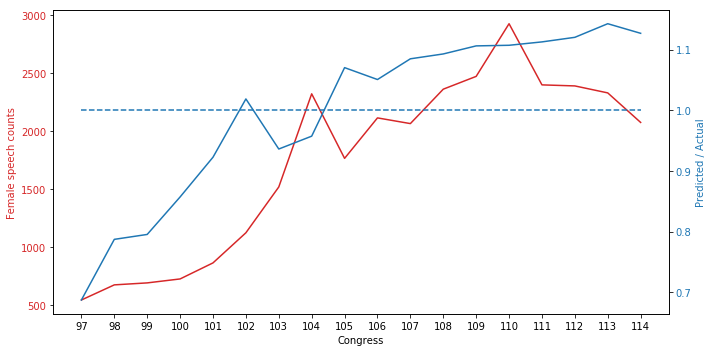

In [40]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Female speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.Female_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()